# Classifying handwritten digits with deep networks

We are going to experiment with the MNIST Dataset: a collection of handwritten digits from 0 to 9.

Attributes will be binary values (on-off) of each dot in a 2D matrix of pixels.
Class: actual digit meant by the writer.


## 1. Data preparation
Before we can build any neural networks we need to import a few things from Keras and prepare our data. The following code extracts the MNIST dataset, provided by Keras, and flattens the 28x28 pixel images into a vector with length 784. Additionally, it modifies the labels from a numeric value 0-9 to categorical class labels.

### Importing libraries

In [3]:
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Layer
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical

from random import randint

import numpy as np

### Installing keras
If you get an import error on `keras`, run one of the next 2 cells to install `keras` in the current Jupyter kernel, and then rerun the import cell. Convert the cell type to Code in order to run it.

### Preparing train and test sets

In [4]:
# Preparing the dataset
# Setup train and test splits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Making a copy before flattening for the next code-segment which displays images
x_train_drawing = x_train

image_size = 784 # 28 x 28
x_train = x_train.reshape(x_train.shape[0], image_size) 
x_test = x_test.reshape(x_test.shape[0], image_size)

# Convert class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Looking at some random digits

It's a good idea to get a sense of the dataset we're working with. Run this code multple times to see new randomly selected digits from the training set. 

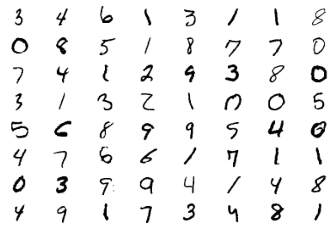

In [5]:
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(x_train_drawing[randint(0, x_train.shape[0])], cmap='Greys')

## 2. Single-layer network

### Setting up network topology

Here we add only one output layer to the layer of input neurons. 

`Sequential` model in keras means a simple sequence of layers.

`Dense` layer is a layer that is connected deeply, which means each neuron in the dense layer receives input from all neurons of its previous layer.

Because the goal is a multi-class classification, we are using _softmax_ as activation function in the output layer.

In [6]:
model = Sequential()
out_layer = Dense(units=num_classes, activation='softmax', input_shape=(image_size,))
model.add(out_layer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Once the model is created, we can config the model with losses and metrics using `model.compile()`, train the model with `model.fit()`, or use the model to do predictions with `model.predict()`.

We can obtain the available metrics from the `history` object returned by the `fit` function.

### Two experiments
The `fit` function has a parameter `batch_size` which represents a number of samples per batch. The error is calculated as an average for all the records in one batch. If unspecified, `batch_size` will default to 32.

### Experiment 1: batch size 32 (default)

Runs for a couple of minutes.

In [7]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,  epochs=50, verbose=False, validation_data=(x_test, y_test))
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Multiple metrics are available to evaluate the performance of your model. You can read about them [here](https://keras.io/api/metrics/).

_Loss_ is the penalty for a bad prediction. That is, loss is a number indicating how bad the model's prediction was on a single example. If the model's prediction is perfect, the loss is zero; otherwise, the loss is greater. The goal of training a model is to find a set of weights and biases that have low loss, on average, across all examples - the error of the model is minimized. In this case we use [cross-entropy](https://machinelearningmastery.com/cross-entropy-for-machine-learning/) to evaluate our error. This is because our classes are categorical and we make information-theoretic-based comparisons between the actual class and the probability of a record to belong to each class.

In [8]:
loss, accuracy  = model.evaluate(x_train, y_train, verbose=False)
print(f'Train loss: {loss:.3}')
print(f'Train accuracy: {accuracy:.3}')

Train loss: 1.76e+02
Train accuracy: 0.908


In [9]:
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Test loss: 2.38e+02
Test accuracy: 0.897


In [10]:
# remembering output weeights
output_weights = out_layer.get_weights()
arr = np.array(output_weights[0])
w = np.transpose(arr)
weights_per_label_long  = w.tolist()
w.shape

(10, 784)

### Experiment 2: batch size 128

In [11]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=4, verbose=False, validation_data=(x_test, y_test))

In [12]:
loss, accuracy  = model.evaluate(x_train, y_train, verbose=False)
print(f'Train loss: {loss:.3}')
print(f'Train accuracy: {accuracy:.3}')

loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Train loss: 90.1
Train accuracy: 0.917
Test loss: 1.53e+02
Test accuracy: 0.898


In [13]:
output_weights = out_layer.get_weights()
arr = np.array(output_weights[0])
w = np.transpose(arr)
weights_per_label = w.tolist()

### Visualizing weights
We do not exactly know what the network learns about each digit - the corresponding pixels in the 28x28 matrix can be quite different for the same digit. But with a single-layer network we can visualize weights to see what the network learned. 

Each output node has a weight coming from every input pixel. For example, the output node "2" has 784 input weights, each mapping the relationship between the corresponding pixel and the class label "2". 
If the weight is high, it means that the model believes there's a high degree of correlation between that pixel and the number 2. 
If the number is very low (or negative), then the network believes there is a very low correlation (perhaps even negative correlation) between that pixel and the number 2.
Thus, if we take the matrix of weights for each pixel
and visualize it, we can "see" what network learned for a particular output node.

We can see what network "sees"!

#### For Experiment 1

In [14]:
from  matplotlib import cm  # color map

cmp = cm.get_cmap("copper", 10)

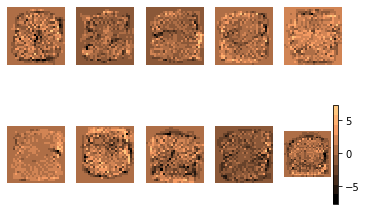

In [15]:
for i in range(len(weights_per_label_long)):
    a = np.array(weights_per_label_long[i])
    pixels = np.reshape(a, (28, 28))
    ax = plt.subplot(2, 5, i+1)
    ax.axis('off')
    plt.imshow(pixels, interpolation='nearest', cmap=cmp)
    
plt.colorbar()

#### For Experiment 2

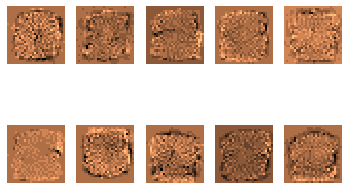

In [16]:

for i in range(len(weights_per_label)):
    a = np.array(weights_per_label[i])
    pixels = np.reshape(a, (28, 28))
    ax = plt.subplot(2, 5, i+1)
    ax.axis('off')
    plt.imshow(pixels, interpolation='nearest',cmap=cmp)


## 3. Adding one hidden layer

Here is a more complex network. It has a single hidden layer with 32 nodes.

In [17]:
model = Sequential()

# The hidden layer requires the special input_shape parameter which should match
# the shape of our training data. Our hidden layer has 32 neurons
model.add(Dense(units=32, activation='sigmoid', input_shape=(image_size,)))

# The output layer has 10 neurons - to predict one of 10 possible digits
model.add(Dense(units=num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=False, validation_data=(x_test, y_test))
history.history

{'loss': [1.3337998390197754,
  0.7935842275619507,
  0.6255095601081848,
  0.538987398147583,
  0.4857591390609741,
  0.4474371671676636,
  0.41742995381355286,
  0.3995513916015625,
  0.3827136754989624,
  0.3642672896385193],
 'accuracy': [0.6533666849136353,
  0.8342999815940857,
  0.8666333556175232,
  0.8799499869346619,
  0.8863999843597412,
  0.8937666416168213,
  0.8965833187103271,
  0.899150013923645,
  0.9017833471298218,
  0.9068833589553833],
 'val_loss': [0.9170818328857422,
  0.6797803640365601,
  0.5722783207893372,
  0.49442172050476074,
  0.4571446180343628,
  0.4228062629699707,
  0.4058566689491272,
  0.3805748522281647,
  0.36872369050979614,
  0.3569209575653076],
 'val_accuracy': [0.8119000196456909,
  0.8619999885559082,
  0.8804000020027161,
  0.8855000138282776,
  0.887499988079071,
  0.8964999914169312,
  0.8980000019073486,
  0.9043999910354614,
  0.9032999873161316,
  0.9072999954223633]}

The history printed above reflects loss and accuracy values for each of 10 epochs.
We can plot them to see how these metrics changed during training.

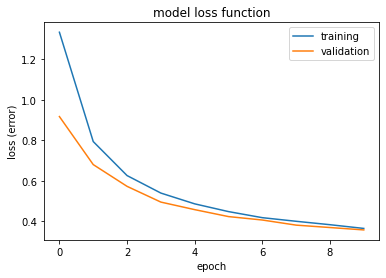

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss function')
plt.ylabel('loss (error)')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [20]:
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Test loss: 0.357
Test accuracy: 0.907


## 4. Preparing to run experiments 

Next we explore how changing the architecture and the parameters of a neural network impacts its performance.  

There are a couple of things we will do repeatedly in these experiments: 

* build a model
* evaluate that model 

So we write two functions that will not only save us time, but more importantly they will also help us compare "apples to apples" -- since we can be sure when we call `create_dense` and `evaluate` our models and training regimen will use the same hyperparameters. Both use some of the variables declared above, and both therefore are explicitly intended for working with the MNIST dataset.

`create_dense` accepts an array of layer sizes, and returns a Keras model of a fully connected neural network with the layer sizes specified. `create_dense([32, 64, 128])` will return a deeply connected neural net with three layers, the first with 32 nodes, second with 64 nodes, and third with 128 nodes (output layer). 

`create_dense` uses the `image_size` variable declared above, which means it assumes the input data will be a vector with 784 units. All the hidden layers use the sigmoid activation function except the output layer, which uses softmax. 

`evaluate` prints a summary of the model, trains the model, and then prints the loss and accuracy. This function by default runs 10 training epochs and uses a fixed batch-size of 128 inputs per batch. It also uses the same MNIST data extracted from Keras that we processed above.

In [21]:
def create_dense(layer_sizes):
    model = Sequential()
    model.add(Dense(layer_sizes[0], activation='sigmoid', input_shape=(image_size,)))

    for s in layer_sizes[1:]:
        model.add(Dense(units = s, activation = 'sigmoid'))
    
    # output layer
    model.add(Dense(units=num_classes, activation='softmax'))

    return model

def evaluate(model, batch_size=128, epochs=10, title="", plot=True):
    print(title)
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=.1, verbose=False)
    loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
    
    if plot:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss function')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['training', 'validation'], loc='best')
        plt.show()

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy function')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['training', 'validation'], loc='best')
        plt.show()
        print()
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')


## 5. Experimenting with different architectures
### 5.1. Number of hidden layers

The following code trains and evaluates models with different numbers of hidden layers. All the hidden layers have 32 nodes. The first model has 1 hidden layer, the second as 2 ... up to four layers. 


In [22]:
for layers in range(1, 5):
    model = create_dense([32] * layers)
    evaluate(model, title="# of hidden layers = {}".format(layers), plot=False)
    print("=============================")
    print()

# of hidden layers = 1
Test loss: 0.364
Test accuracy: 0.908

# of hidden layers = 2
Test loss: 0.705
Test accuracy: 0.872

# of hidden layers = 3
Test loss: 1.71
Test accuracy: 0.497

# of hidden layers = 4
Test loss: 2.28
Test accuracy: 0.113



### 5.2. Deeper networks need more epochs

One of the factors at play is that deeper networks take more time to train. This has to do with backpropagation, gradient descent, and the way optimization algorithms work. Let's see what happens when we let the 3-layer network that had mediocre performance above train for longer.

In [23]:
model = create_dense([32, 32, 32])
evaluate(model, epochs=100, plot=False)


Test loss: 0.298
Test accuracy: 0.916


### 5.3. Number of nodes per layer

Another way to add complexity is to add more nodes to each hidden layer. The following code creates several single-layer neural networks, with increasingly more nodes in that layer. 

In [24]:
for nodes in [32, 64, 128, 256, 512, 1024, 2048]:
    model = create_dense([nodes])
    evaluate(model, epochs=10, plot=False, title="# of nodes in the hidden layer = {}".format(nodes))
    print("=============================")
    print()

# of nodes in the hidden layer = 32
Test loss: 0.38
Test accuracy: 0.902

# of nodes in the hidden layer = 64
Test loss: 0.302
Test accuracy: 0.923

# of nodes in the hidden layer = 128
Test loss: 0.25
Test accuracy: 0.93

# of nodes in the hidden layer = 256
Test loss: 0.217
Test accuracy: 0.939

# of nodes in the hidden layer = 512
Test loss: 0.193
Test accuracy: 0.944

# of nodes in the hidden layer = 1024
Test loss: 0.166
Test accuracy: 0.953

# of nodes in the hidden layer = 2048
Test loss: 0.146
Test accuracy: 0.956



### 5.4. Number of layers and number of nodes per layer

Now that we've looked at the number of nodes and the number of layers in an isolated context, lets look at what happens as we combine these two factors.

In [25]:
nodes_per_layer = 32
for layers in [1, 2, 3, 4, 5]:
    model = create_dense([nodes_per_layer] * layers)
    evaluate(model, epochs=10*layers, plot=False, 
             title="# of hidden layers = {} with {} nodes per layer and {} epochs".format(layers,nodes_per_layer, 10*layers))
    print("=============================")
    print()

# of hidden layers = 1 with 32 nodes per layer and 10 epochs
Test loss: 0.374
Test accuracy: 0.907

# of hidden layers = 2 with 32 nodes per layer and 20 epochs
Test loss: 0.425
Test accuracy: 0.899

# of hidden layers = 3 with 32 nodes per layer and 30 epochs
Test loss: 0.64
Test accuracy: 0.852

# of hidden layers = 4 with 32 nodes per layer and 40 epochs
Test loss: 1.2
Test accuracy: 0.585

# of hidden layers = 5 with 32 nodes per layer and 50 epochs
Test loss: 2.27
Test accuracy: 0.115



In [26]:
nodes_per_layer = 128
for layers in [1, 2, 3, 4, 5]:
    model = create_dense([nodes_per_layer] * layers)
    evaluate(model, epochs=10*layers, plot=False, 
             title="# of hidden layers = {} with {} nodes per layer and {} epochs".format(layers,nodes_per_layer, 10*layers))
    print("=============================")
    print()

# of hidden layers = 1 with 128 nodes per layer and 10 epochs
Test loss: 0.241
Test accuracy: 0.934

# of hidden layers = 2 with 128 nodes per layer and 20 epochs
Test loss: 0.248
Test accuracy: 0.933

# of hidden layers = 3 with 128 nodes per layer and 30 epochs
Test loss: 0.284
Test accuracy: 0.926

# of hidden layers = 4 with 128 nodes per layer and 40 epochs
Test loss: 0.422
Test accuracy: 0.906

# of hidden layers = 5 with 128 nodes per layer and 50 epochs
Test loss: 1.7
Test accuracy: 0.374



In [29]:
nodes_per_layer = 512
for layers in [1, 2, 3, 4, 5]:
    model = create_dense([nodes_per_layer] * layers)
    evaluate(model, epochs=10*layers, plot=False, 
             title="# of hidden layers = {} with {} nodes per layer and {} epochs".format(layers,nodes_per_layer, 10*layers))
    print("=============================")
    print()

# of hidden layers = 1 with 512 nodes per layer and 10 epochs
Test loss: 0.189
Test accuracy: 0.947

# of hidden layers = 2 with 512 nodes per layer and 20 epochs
Test loss: 0.201
Test accuracy: 0.942

# of hidden layers = 3 with 512 nodes per layer and 30 epochs
Test loss: 0.218
Test accuracy: 0.937

# of hidden layers = 4 with 512 nodes per layer and 40 epochs
Test loss: 0.248
Test accuracy: 0.935

# of hidden layers = 5 with 512 nodes per layer and 50 epochs
Test loss: 0.383
Test accuracy: 0.907



In [30]:
nodes_per_layer = 2024
for layers in [1, 2]:
    model = create_dense([nodes_per_layer] * layers)
    evaluate(model, epochs=10*layers, plot=False, 
             title="# of hidden layers = {} with {} nodes per layer and {} epochs".format(layers,nodes_per_layer, 10*layers))
    print("=============================")
    print()

# of hidden layers = 1 with 2024 nodes per layer and 10 epochs
Test loss: 0.149
Test accuracy: 0.956

# of hidden layers = 2 with 2024 nodes per layer and 20 epochs
Test loss: 0.175
Test accuracy: 0.948



## 6. Experiment with small batch size

During the training we can update weights with different frequency. We can do it in threee possible ways:

- __Stochastic__ gradient descent: show one input vector at a time and update weights after each instance. This approach is problematic, because when the network sees only 1 record, it can sometimes reach a zero error (perfect classification), and stop training. 
- __Full__ gradient descent: show the entire dataset during one epoch and update weights with average deltas - once per iteration. This aalso can be problematic, because we have only one update per epoch, and the network is less flexible in adjusting its weights.
- __Batch__ gradient descent: show n instances (batch) at a time, and update after each batch.

Models with several layers need to not only train for longer, but also need more corrections per epoch. By decreasing the batch size, we can increase the number of overall corrections per epoch. We also ensure it gets more fine-grained change by adjusting to error over smaller batches. 

In the example below, we can force a model that did not learn well in previous experiments (37% accuracy) to achieve a moderately respectable accuracy by decreasing the batch size. The performance is still not great, but it's worth mentioning that with patience and computational power we can make a model that looked like total junk perform decently. 

Still our effort would probably be better spent on more promising models. 

In [31]:
model = create_dense([128] * 5)
evaluate(model, batch_size=16, epochs=50, plot=False)


Test loss: 0.388
Test accuracy: 0.886


# Best result: 3-layer network with many nodes and smaller batches

We are now persuaded that the network with a single hidden layer, a lot of neurons in a hidden layer, and a small batch size learns the best. Let's visualize the performance of our best model (see results of 5.3).

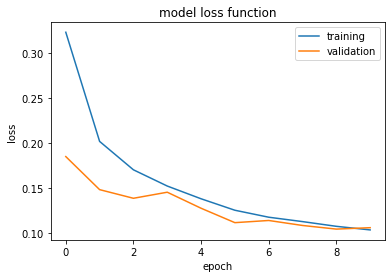

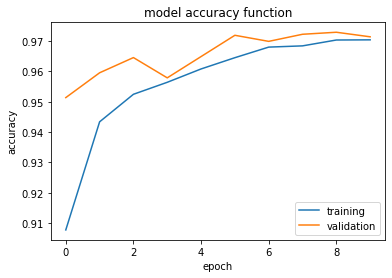


Test loss: 0.119
Test accuracy: 0.964


In [32]:
model = create_dense([2048] * 1)
evaluate(model, batch_size=16, epochs=10, plot=True)

Copyright &copy; 2022 Marina Barsky. All rights reserved.